---
title: "Instrumental variable analysis with observed covariates"
mathjax: true
toc: true
toc_sticky: true
categories: [data science, statistics]
---

Instrumental variable (IV) analysis can be helpful to deconfound an exposure from an outcome. A common example of the confound assumes the variable is unobserved. But what if it is observed? What is the proper handling of it? Given two-stage least squares, do we include it in the first stage, second stage, both stages or none? Let's run an experiment.


In [8]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from utils import draw_causal_graph, standardize

In [2]:
RANDOM_SEED = 73
np.random.seed(RANDOM_SEED)
sns.set_context("talk")
sns.set_palette("colorblind")
cb_palette = sns.color_palette()

# Causal graph of example dataset, with observed confound

We'll return to the wages and education example from Chapter 14 of Statistical Rethinking. We'll use `O` to denote an obesrved confound.

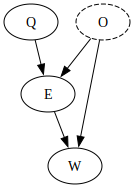

In [4]:
draw_causal_graph(
    edge_list=[("Q", "E"), ("O", "E"), ("O", "W"), ("E", "W")],
    node_props={"O": {"style": "dashed"}},
    graph_direction="TD",
)

Per usual, we'll use this to generate a simulated dataset. We'll use the same code but this time derive `R` from `W`. The rationale being those with higher wages are more likely to be rich. We’ll still making the influence of education on wages (`bEW_sim`) equal to 0. We'll want to get this value back in our statistical models, even though we'll be using `R` as our ultimate outcome variable.

A key conceptual point is use of a logit link function to produce `R` from `W`.  Additionally, we'll make use of a [binomial generalized linear model](https://benslack19.github.io/data%20science/statistics/multilevel_modeling_01/).

In [5]:
N = 500
bEW_sim = 0

O_sim = np.random.normal(size=N)
Q_sim = np.random.randint(1, 5, N)
E_sim = np.random.normal(loc=O_sim + Q_sim, size=N)
W_sim = np.random.normal(loc=O_sim + bEW_sim * E_sim, size=N)
dat_sim = pd.DataFrame.from_dict(
    {"W": standardize(W_sim),  "O": standardize(O_sim), "E": standardize(E_sim), "Q": standardize(Q_sim)}
)
dat_sim.head()

,W,O,E,Q
0,1.147366,0.622195,1.442103,0.428599
1,1.153508,2.236537,0.386141,-1.372236
2,0.948497,2.557589,0.413627,-0.471819
3,-0.137755,0.296598,0.193661,-0.471819
4,-1.653446,-1.530822,-2.076577,-0.471819


# No covariate added

In [9]:
# First stage: Regress education on Q
first_stage = sm.OLS(dat_sim["E"], sm.add_constant(dat_sim["Q"])).fit()

# Predicted education added to df
dat_sim["E_hat"] = first_stage.predict(sm.add_constant(dat_sim["Q"]))
dat_sim.head()

,W,O,E,Q,E_hat
0,1.147366,0.622195,1.442103,0.428599,0.292607
1,1.153508,2.236537,0.386141,-1.372236,-0.936835
2,0.948497,2.557589,0.413627,-0.471819,-0.322114
3,-0.137755,0.296598,0.193661,-0.471819,-0.322114
4,-1.653446,-1.530822,-2.076577,-0.471819,-0.322114


In [10]:
# Second stage: Regress wages on predicted education (instrumented)
second_stage = sm.OLS(dat_sim["W"], sm.add_constant(dat_sim["E_hat"])).fit()

# Summary of the second stage regression
second_stage.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5562
Date:                Thu, 20 Jun 2024   Prob (F-statistic):              0.456
Time:                        22:45:32   Log-Likelihood:                -709.19
No. Observations:                 500   AIC:                             1422.
Df Residuals:                     498   BIC:                             1431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.776e-17      0.045    6.2e-16      1.000      -0.088       0.088
E_hat          0.0489      0.066      0.746      0.456      -0.080       0.178
==============================================================================
Omnibus:                        0.243   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.885   Jarque-Bera (JB):                0.357
Skew:                           0.014   Prob(JB):                        0.836
Kurtosis:                       2.872   Cond. No.                         1.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Covariate added only to first stage

In [11]:
# First stage: Regress education on Q, with O
first_stage = sm.OLS(dat_sim["E"], sm.add_constant(dat_sim[["Q", "O"]])).fit()

# Predicted education added to df
dat_sim["E_hat"] = first_stage.predict(sm.add_constant(dat_sim[["Q", "O"]]))
dat_sim.head()

,W,O,E,Q,E_hat
0,1.147366,0.622195,1.442103,0.428599,0.596635
1,1.153508,2.236537,0.386141,-1.372236,0.241425
2,0.948497,2.557589,0.413627,-0.471819,0.993109
3,-0.137755,0.296598,0.193661,-0.471819,-0.157361
4,-1.653446,-1.530822,-2.076577,-0.471819,-1.087215


In [12]:
# Second stage: Regress wages on predicted education (instrumented)
second_stage = sm.OLS(dat_sim["W"], sm.add_constant(dat_sim["E_hat"])).fit()

# Summary of the second stage regression
second_stage.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     123.6
Date:                Thu, 20 Jun 2024   Prob (F-statistic):           8.45e-26
Time:                        22:47:42   Log-Likelihood:                -654.05
No. Observations:                 500   AIC:                             1312.
Df Residuals:                     498   BIC:                             1321.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.776e-17      0.040   6.92e-16      1.000      -0.079       0.079
E_hat          0.5240      0.047     11.117      0.000       0.431       0.617
==============================================================================
Omnibus:                        1.255   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.534   Jarque-Bera (JB):                1.224
Skew:                          -0.005   Prob(JB):                        0.542
Kurtosis:                       2.758   Cond. No.                         1.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Covariate added only to second stage

In [14]:
# First stage: Regress education on Q, with O
first_stage = sm.OLS(dat_sim["E"], sm.add_constant(dat_sim["Q"])).fit()

# Predicted education added to df
dat_sim["E_hat"] = first_stage.predict(sm.add_constant(dat_sim["Q"]))
dat_sim.head()

,W,O,E,Q,E_hat
0,1.147366,0.622195,1.442103,0.428599,0.292607
1,1.153508,2.236537,0.386141,-1.372236,-0.936835
2,0.948497,2.557589,0.413627,-0.471819,-0.322114
3,-0.137755,0.296598,0.193661,-0.471819,-0.322114
4,-1.653446,-1.530822,-2.076577,-0.471819,-0.322114


In [15]:
# Second stage: Regress wages on predicted education (instrumented)
second_stage = sm.OLS(dat_sim["W"], sm.add_constant(dat_sim[["E_hat", "O"]])).fit()

# Summary of the second stage regression
second_stage.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     242.6
Date:                Thu, 20 Jun 2024   Prob (F-statistic):           2.97e-74
Time:                        22:49:00   Log-Likelihood:                -539.14
No. Observations:                 500   AIC:                             1084.
Df Residuals:                     497   BIC:                             1097.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.776e-17      0.032    8.7e-16      1.000      -0.063       0.063
E_hat         -0.0104      0.047     -0.223      0.824      -0.102       0.082
O              0.7033      0.032     22.005      0.000       0.640       0.766
==============================================================================
Omnibus:                        1.145   Durbin-Watson:                   1.784
Prob(Omnibus):                  0.564   Jarque-Bera (JB):                1.210
Skew:                          -0.068   Prob(JB):                        0.546
Kurtosis:                       2.801   Cond. No.                         1.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Covariate added to both stages

In [18]:
# First stage: Regress education on Q, with O
first_stage = sm.OLS(dat_sim["E"], sm.add_constant(dat_sim[["Q", "O"]])).fit()

# Predicted education added to df
dat_sim["E_hat"] = first_stage.predict(sm.add_constant(dat_sim[["Q", "O"]]))
dat_sim.head()

,W,O,E,Q,E_hat
0,1.147366,0.622195,1.442103,0.428599,0.596635
1,1.153508,2.236537,0.386141,-1.372236,0.241425
2,0.948497,2.557589,0.413627,-0.471819,0.993109
3,-0.137755,0.296598,0.193661,-0.471819,-0.157361
4,-1.653446,-1.530822,-2.076577,-0.471819,-1.087215


In [19]:
# Second stage: Regress wages on predicted education (instrumented)
second_stage = sm.OLS(dat_sim["W"], sm.add_constant(dat_sim[["E_hat", "O"]])).fit()

# Summary of the second stage regression
second_stage.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     242.6
Date:                Thu, 20 Jun 2024   Prob (F-statistic):           2.97e-74
Time:                        22:52:07   Log-Likelihood:                -539.14
No. Observations:                 500   AIC:                             1084.
Df Residuals:                     497   BIC:                             1097.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.776e-17      0.032    8.7e-16      1.000      -0.063       0.063
E_hat         -0.0109      0.049     -0.223      0.824      -0.107       0.085
O              0.7088      0.042     17.029      0.000       0.627       0.791
==============================================================================
Omnibus:                        1.145   Durbin-Watson:                   1.784
Prob(Omnibus):                  0.564   Jarque-Bera (JB):                1.210
Skew:                          -0.068   Prob(JB):                        0.546
Kurtosis:                       2.801   Cond. No.                         2.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Comparison of estimates

# Summary and acknowledgements



In [199]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Wed Jun 12 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

pymc      : 5.15.0
matplotlib: 3.8.4
scipy     : 1.13.0
seaborn   : 0.13.2
numpy     : 1.26.4
pandas    : 2.2.2
arviz     : 0.18.0
pytensor  : 2.20.0

Watermark: 2.4.3

